# Item Nonresponse Demo

In [1]:
# To generate and store data.
import numpy as np
import pandas as pd
import scipy.stats as stats

# To visualize data.
import matplotlib.pyplot as plt

# To fit linear regression model.
from sklearn.linear_model import LinearRegression, LogisticRegression

# Install and import missingno to visualize missingness patterns. (Uncomment first line to install missingno.)
# !pip install missingno
import missingno as msno

# # There is a SciPy issue that won't affect our work, but a warning exists
# # and an update is not imminent.
import warnings
warnings.filterwarnings(action="ignore")

# To render plots in the notebook.
%matplotlib inline

### Let's generate some data. Specifically, we'll generate age, partnered, children, and income data, where income is linearly related to age, partnered, and children.

In [2]:
# To ensure we get the same results.
np.random.seed(42)

# Generate data.
age = np.round(np.random.uniform(20, 60, size = 100))
partnered = np.random.binomial(1, 0.8, size = 100)
children = np.random.poisson(2, size = 100)
income = 15000 + 750 * age + 20000 * partnered - 2500 * children + np.random.normal(0, 20000, size = 100)

# Ensure income is not negative!
income = [i if i >= 0 else 0 for i in income]

# Combine our results into one dataframe.
df = pd.DataFrame({'age': age,
                   'partnered': partnered,
                   'children': children,
                   'income': income})

# Check the first five rows of df to make sure we did this properly.
df.head()

,age,partnered,children,income
0,35.0,1,1,56531.361287
1,58.0,1,2,93026.182530
2,49.0,1,0,42693.010819
3,44.0,1,0,83680.128218
4,26.0,0,1,28845.520835


### Run this cell. These are functions that will generate missing values according to MCAR, MAR, or NMAR.

In [3]:
def create_mcar_column(df, missing_column = 'income', p_missing = 0.01, random_state = 42):
    """
    Creates missingness indicator column, where data are MCAR (missing completely at random).
    
    User must specify:
        df = the pandas DataFrame the user wants to read in for analysis
        column = the name of the column in df that is missing
        p_missing = the proportion of observations that are missing
        
    Function returns:
        mcar_column = a column that indicates whether data are missing, assuming MCAR
    """
    np.random.seed(random_state)
    
    mcar_indices = [df.sample(n = 1).index[0] for i in range(round(p_missing * df.shape[0]))]
    
    while len(set(mcar_indices)) < round(p_missing * df.shape[0]):
        mcar_indices.append(df.sample(n = 1).index[0])
    
    mcar_column = [1 if i in mcar_indices else 0 for i in range(df.shape[0])]
    
    return mcar_column

def create_mar_column(df, missing_column = 'income', depends_on = 'age', method = 'linear', p_missing = 0.01, random_state = 42):
    """
    Creates missingness indicator column, where data are MAR (missing at random).
    
    User must specify:
        df = the pandas DataFrame the user wants to read in for analysis
        missing_column = the name of the column in df that is missing
        depends_on = the name of the column in df which affects the missingness
        method = 'linear' or 'quadratic'
            - 'linear' means the probability of missingness is linearly related to the depends_on variable
            - 'quadratic' means the probability of missingness is quadratically related to the depends_on variable
        p_missing = the proportion of observations that are missing
        
    Function returns:
        mar_column = a column that indicates whether data are missing, assuming MAR
    """
    np.random.seed(random_state)
    
    if method == 'linear':
        mar_indices = [df.sample(n = 1, weights = depends_on).index[0] for i in range(round(p_missing * df.shape[0]))]

        while len(set(mar_indices)) < round(p_missing * df.shape[0]):
            mar_indices.append(df.sample(n = 1, weights = depends_on).index[0])
    
    elif method == 'quadratic':
        mar_indices = [df.sample(n = 1, weights = df[depends_on] ** 2).index[0] for i in range(round(p_missing * df.shape[0]))]

        while len(set(mar_indices)) < round(p_missing * df.shape[0]):
            mar_indices.append(df.sample(n = 1, weights = df[depends_on] ** 2).index[0])

    mar_column = [1 if i in mar_indices else 0 for i in range(df.shape[0])]
        
    return mar_column

def create_nmar_column(df, missing_column = 'income', method = 'linear', p_missing = 0.01, random_state = 42):
    """
    Creates missingness indicator column, where data are NMAR (not missing at random).
    
    User must specify:
        df = the pandas DataFrame the user wants to read in for analysis
        missing_column = the name of the column in df that is missing
        method = 'linear' or 'quadratic'
            - 'linear' means the probability of missingness is linearly related to the depends_on variable
            - 'quadratic' means the probability of missingness is quadratically related to the depends_on variable
        p_missing = the proportion of observations that are missing
        
    Function returns:
        nmar_column = a column that indicates whether data are missing, assuming NMAR
    """
    np.random.seed(random_state)
    
    if method == 'linear':
        nmar_indices = [df.sample(n = 1, weights = missing_column).index[0] for i in range(round(p_missing * df.shape[0]))]

        while len(set(nmar_indices)) < round(p_missing * df.shape[0]):
            nmar_indices.append(df.sample(n = 1, weights = missing_column).index[0])
    
    elif method == 'quadratic':
        nmar_indices = [df.sample(n = 1, weights = df[missing_column] ** 2).index[0] for i in range(round(p_missing * df.shape[0]))]

        while len(set(nmar_indices)) < round(p_missing * df.shape[0]):
            nmar_indices.append(df.sample(n = 1, weights = df[missing_column] ** 2).index[0])
            
    nmar_column = [1 if i in nmar_indices else 0 for i in range(df.shape[0])]
    
    return nmar_column

### Let's generate some missing data!

In [4]:
df['age_missingness'] = create_mcar_column(df,
                                           missing_column = 'age',                                           
                                           p_missing = 0.3,
                                           random_state = 42)

df['partnered_missingness'] = create_mar_column(df,
                                                missing_column = 'partnered',
                                                method = 'linear',
                                                p_missing = 0.2,
                                                random_state = 42)

df['income_missingness'] = create_nmar_column(df,
                                              missing_column = 'income',
                                              method = 'quadratic',
                                              p_missing = 0.2,
                                              random_state = 42)

print(df['age_missingness'].value_counts())
print(df['partnered_missingness'].value_counts())
print(df['income_missingness'].value_counts())

0    70
1    30
Name: age_missingness, dtype: int64
0    80
1    20
Name: partnered_missingness, dtype: int64
0    80
1    20
Name: income_missingness, dtype: int64


In [5]:
df.head()

,age,partnered,children,income,age_missingness,partnered_missingness,income_missingness
0,35.0,1,1,56531.361287,0,0,0
1,58.0,1,2,93026.182530,0,1,1
2,49.0,1,0,42693.010819,0,0,0
3,44.0,1,0,83680.128218,0,0,1
4,26.0,0,1,28845.520835,0,0,0


### Let's create a new dataframe with the values actually missing.

In [6]:
df_missing = pd.DataFrame(df['children'])

df_missing['age'] = [df.loc[i,'age'] if df.loc[i,'age_missingness'] == 0 else np.nan for i in range(100)]
df_missing['partnered'] = [df.loc[i,'partnered'] if df.loc[i,'partnered_missingness'] == 0 else np.nan for i in range(100)]
df_missing['income'] = [df.loc[i,'income'] if df.loc[i,'income_missingness'] == 0 else np.nan for i in range(100)]

df_missing.head()

,children,age,partnered,income
0,1,35.0,1.0,56531.361287
1,2,58.0,NaN,NaN
2,0,49.0,1.0,42693.010819
3,0,44.0,1.0,NaN
4,1,26.0,0.0,28845.520835


### Let's visualize our missing data.
- Children is 100% observed.
- Age is missing completely at random and is missing 30% of its observations.
- Partnered is missing at random and is missing 20% of its observations.
- Income is missing at random and is missing 20% of its observations.

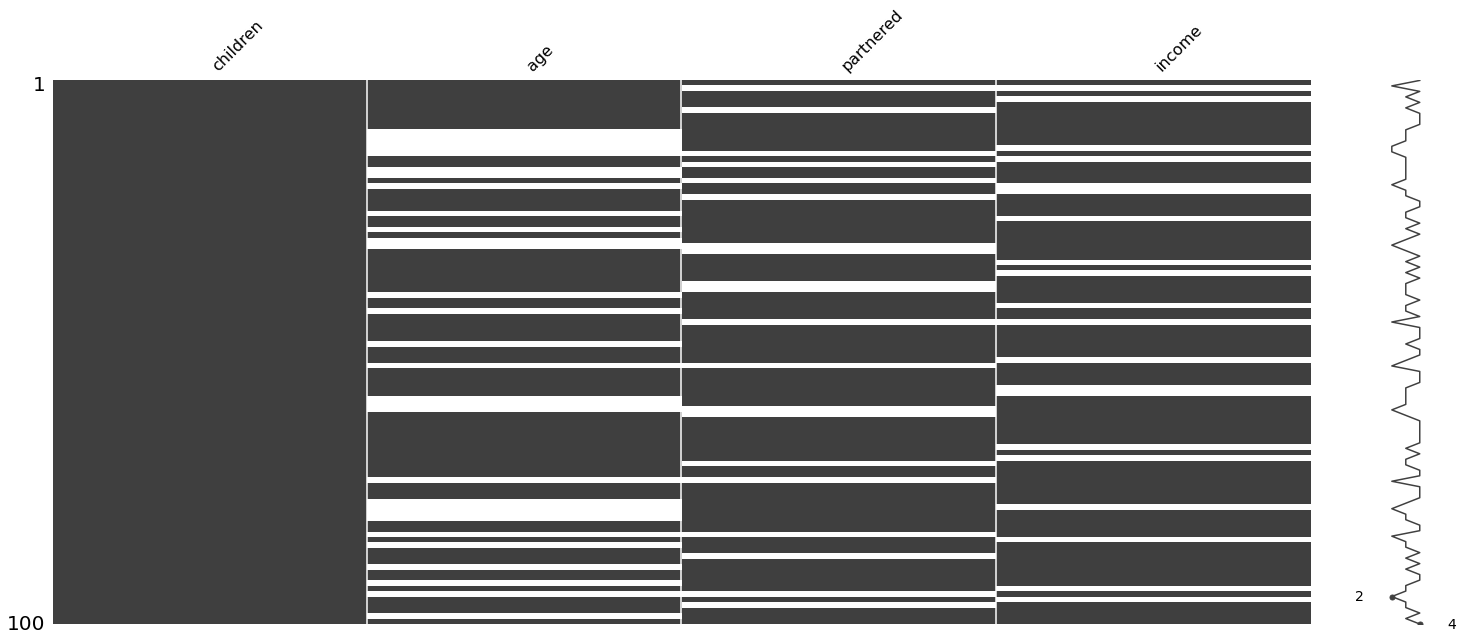

In [7]:
msno.matrix(df_missing);

### Generate histograms.

In [8]:
def compare_histograms(df, imputed_column, original_column, missingness_column, x_label, y_label = 'Frequency'):
    fig, (ax0, ax1) = plt.subplots(nrows = 2, ncols = 1, figsize = (16,9))

    # Set axes of histograms.
    mode = stats.mode(df[imputed_column])
    rnge = max(df[original_column]) - min(df[original_column])
    xmin = min(df[original_column]) - 0.02 * rnge
    xmax = max(df[original_column]) + 0.02 * rnge
    ymax = 1.3 * (mode[1][0] + df[df[original_column] == mode[0][0]].shape[0])

    ax0.set_xlim(xmin, xmax)
    ax0.set_ylim(0, ymax)
    ax1.set_xlim(xmin, xmax)
    ax1.set_ylim(0, ymax)

    # Set top labels.
    ax0.set_title('Real Histogram', position = (0,1), ha = 'left', fontsize = 25)
    ax0.set_xlabel(x_label, position = (0,0), ha = 'left', fontsize = 25, color = 'grey', alpha = 0.85)
    ax0.set_ylabel(y_label, position = (0,1), ha = 'right', va = 'top', fontsize = 25, rotation = 0, color = 'grey', alpha = 0.85)
    ax0.set_xticks([])
    ax0.set_yticks([])

    # Generate top histogram.
    ax0.hist(df[original_column], bins = 15, color = '#185fad', alpha = 0.75, label = '')
    ax0.axvline(np.mean(df[original_column]), color = '#185fad', lw = 5, label = 'True Mean')
    ax0.legend(prop={'size': 15}, loc = 1)

    # Set bottom labels.
    ax1.set_title('Observed + Imputed Histogram', position = (0,1), ha = 'left', fontsize = 25)
    ax1.set_xlabel(x_label, position = (0,0), ha = 'left', fontsize = 25, color = 'grey', alpha = 0.85)
    ax1.set_ylabel(y_label, position = (0,1), ha = 'right', va = 'top', fontsize = 25, rotation = 0, color = 'grey', alpha = 0.85)

    # Generate bottom histogram.
    ax1.hist([df[imputed_column][df[missingness_column] == 0], df[imputed_column][df[missingness_column] == 1]], bins = 15, color = ['#185fad','orange'], alpha = 0.75, label = '', stacked = True)
    ax1.axvline(np.mean(df[original_column]), color = '#185fad', lw = 5, label = 'True Mean')
    ax1.axvline(np.mean(df[original_column][df[missingness_column] == 0]), color = 'grey', alpha = 0.5, lw = 5, label = 'Observed Mean')
    ax1.axvline(np.mean(df[imputed_column]), color = 'orange', lw = 5, label = 'Observed and Imputed Mean')
    ax1.legend(prop={'size': 15}, loc = 1)

    plt.show();

### Examine various imputation methods.

##### Mean Imputation

In [9]:
def impute_mean(df, impute_column, missingness_column):
    """
    Imputes mean for any value where data is marked missing.
    
    User must specify:
        df = the pandas DataFrame the user wants to read in for analysis
        impute_column = the name of the column in df that is missing
        missingness_column = the name of the missingness indicator column
        
    Function returns:
        mean_impute = a column with the mean imputed for any missing value.
    """
    mean_impute = [df.loc[i,impute_column] if df.loc[i,missingness_column] == 0 else np.mean(df[impute_column]) for i in range(df.shape[0])]
    
    return mean_impute

In [10]:
df['age_mean_imputed'] = impute_mean(df, 'age', 'age_missingness')

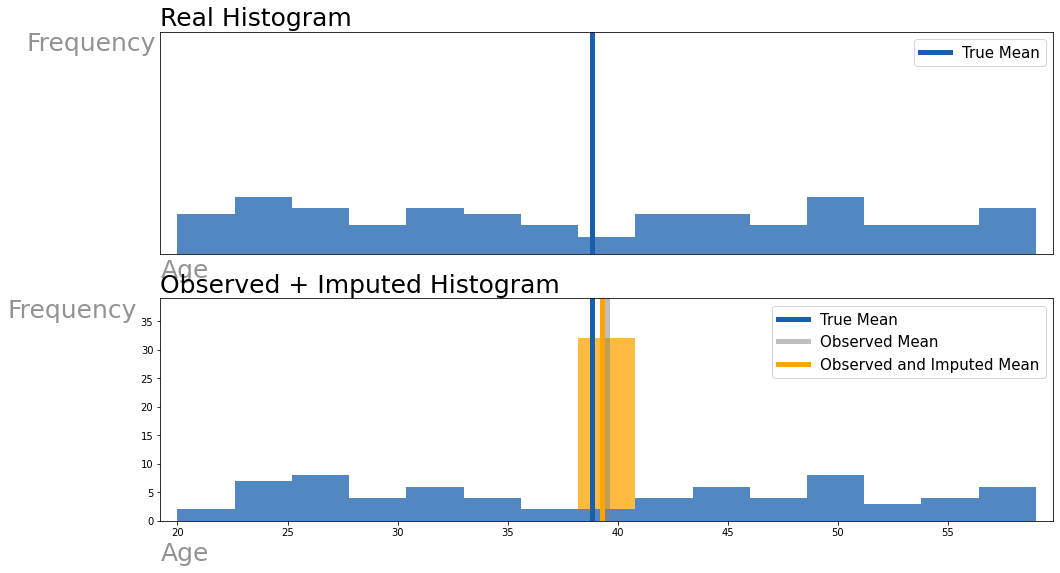

In [11]:
compare_histograms(df = df,
                   imputed_column = 'age_mean_imputed',
                   original_column = 'age',
                   missingness_column = 'age_missingness',
                   x_label = 'Age',
                   y_label = 'Frequency')

How to read the above chart:
- The blue line is the true mean of all data (observed and unobserved).
- The grey line is the mean of just the observed data. (i.e. no imputation)
- The orange line is the mean of the observed and imputed data.

$$
\begin{eqnarray*}
s &=& \sqrt{\frac{\sum_{i=1}^n(x_i - \bar{x})^2}{n-1}} \\
\text{impute mean for values } k+1 \text{ through } n \Rightarrow s &=& \sqrt{\frac{\sum_{i=1}^k(x_i - \bar{x})^2}{n-1} + \frac{\sum_{i=k+1}^n(\bar{x} - \bar{x})^2}{n-1}} \\
&=& \sqrt{\frac{\sum_{i=1}^k(x_i - \bar{x})^2}{n-1}} \\
&\Rightarrow& \text{the denominator increases but numerator remains fixed} \\
&\Rightarrow& \text{the sample standard deviation is underestimated} \\
&\Rightarrow& \text{confidence intervals relying on the mean are narrower than they should be}
\end{eqnarray*}
$$

##### Median Imputation

In [12]:
def impute_median(df, impute_column, missingness_column):
    """
    Imputes median for any value where data is marked missing.
    
    User must specify:
        df = the pandas DataFrame the user wants to read in for analysis
        impute_column = the name of the column in df that is missing
        missingness_column = the name of the missingness indicator column
        
    Function returns:
        median_impute = a column with the median imputed for any missing value.
    """
    median_impute = [df.loc[i,impute_column] if df.loc[i,missingness_column] == 0 else np.median(df[impute_column]) for i in range(df.shape[0])]
    
    return median_impute

In [13]:
df['age_median_imputed'] = impute_median(df, 'age', 'age_missingness')

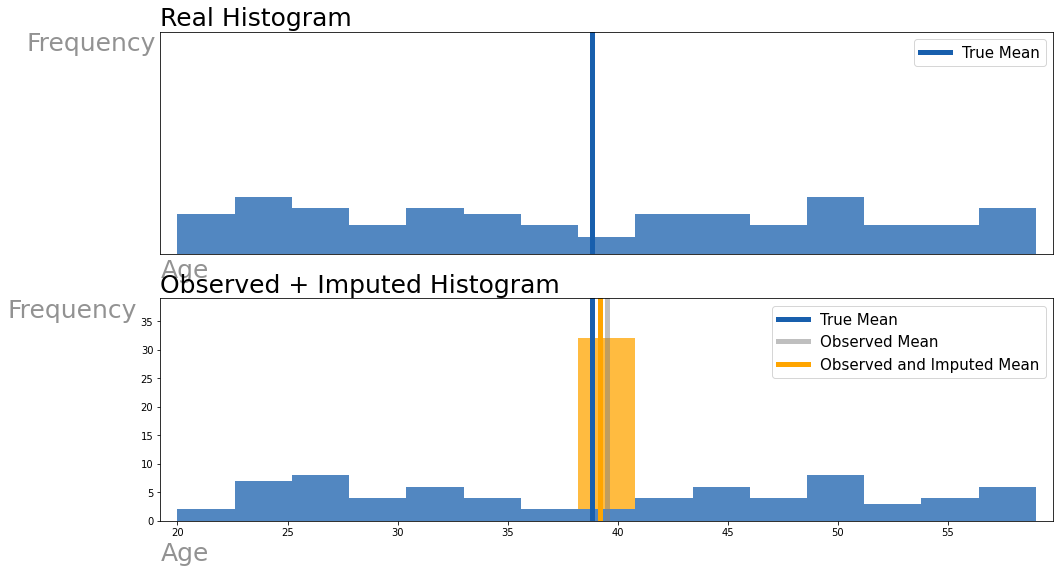

In [14]:
compare_histograms(df = df,
                   imputed_column = 'age_median_imputed',
                   original_column = 'age',
                   missingness_column = 'age_missingness',
                   x_label = 'Age',
                   y_label = 'Frequency')

##### Mode Imputation

In [15]:
def impute_mode(df, impute_column, missingness_column):
    """
    Imputes mode for any value where data is marked missing.
    
    User must specify:
        df = the pandas DataFrame the user wants to read in for analysis
        impute_column = the name of the column in df that is missing
        missingness_column = the name of the missingness indicator column
        
    Function returns:
        mode_impute = a column with the mode imputed for any missing value.
    """
    mode_impute = [df.loc[i,impute_column] if df.loc[i,missingness_column] == 0 else stats.mode(df[impute_column])[0][0] for i in range(df.shape[0])]
    
    return mode_impute

In [16]:
df['age_mode_imputed'] = impute_mode(df, 'age', 'age_missingness')

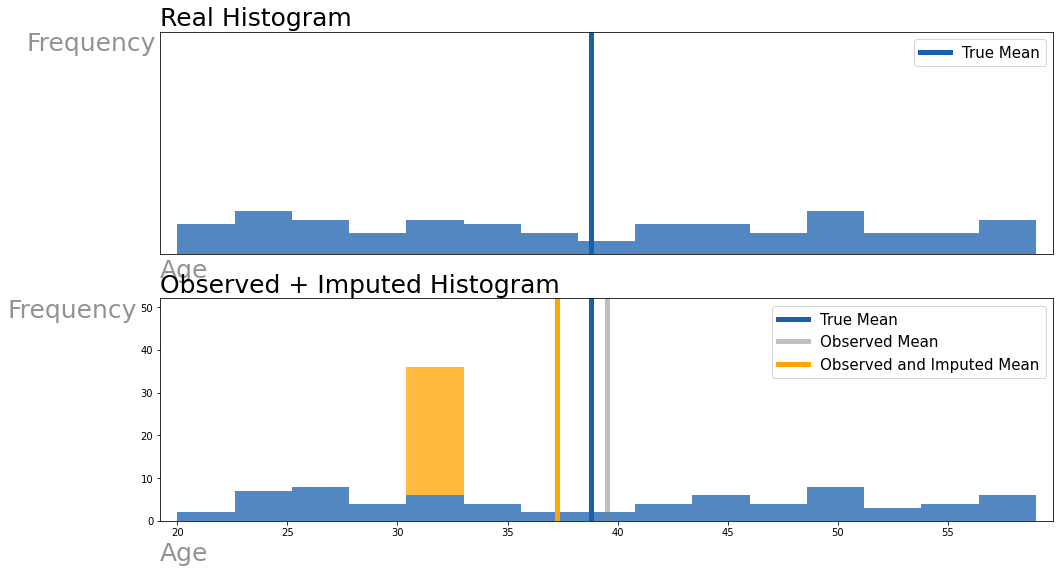

In [17]:
compare_histograms(df = df,
                   imputed_column = 'age_mode_imputed',
                   original_column = 'age',
                   missingness_column = 'age_missingness',
                   x_label = 'Age',
                   y_label = 'Frequency')

##### Regression Imputation

In [18]:
def regression_imputation(df, impute_column, X_columns, missingness_column, regression = 'linear'):
    """
    Fits regression line to observed data, then imputes regression prediction
    for any value where data is marked missing.
    
    User must specify:
        df = the pandas DataFrame the user wants to read in for analysis
        impute_column = the name of the column in df that is missing
        X_columns = the names of the columns used as independent variables
                    to impute the missing value
        missingness_column = the name of the missingness indicator column
        regression = the type of regression to run; only supports 'linear'
                     for LinearRegression and 'logistic' for LogisticRegression
        
    Function returns:
        regression_impute = a column with the regression value imputed for any missing value.
        
    NOTE: Only set up to do linear or logistic regression.
    """
    
    if regression == 'linear':
        model = LinearRegression()
    elif regression == 'logistic':
        model = LogisticRegression()
    
    model.fit(df[X_columns], df[impute_column])
    
    regression_impute = [df.loc[i,'age'] if df.loc[i,'age_missingness'] == 0
                         else model.predict(pd.DataFrame(df.loc[i,['children', 'partnered', 'income']]).T)[0] 
                         for i in range(df.shape[0])]
    
    return regression_impute

In [19]:
df['age_regression_imputed'] = regression_imputation(df, 'age', ['children', 'partnered', 'income'], 'age_missingness')

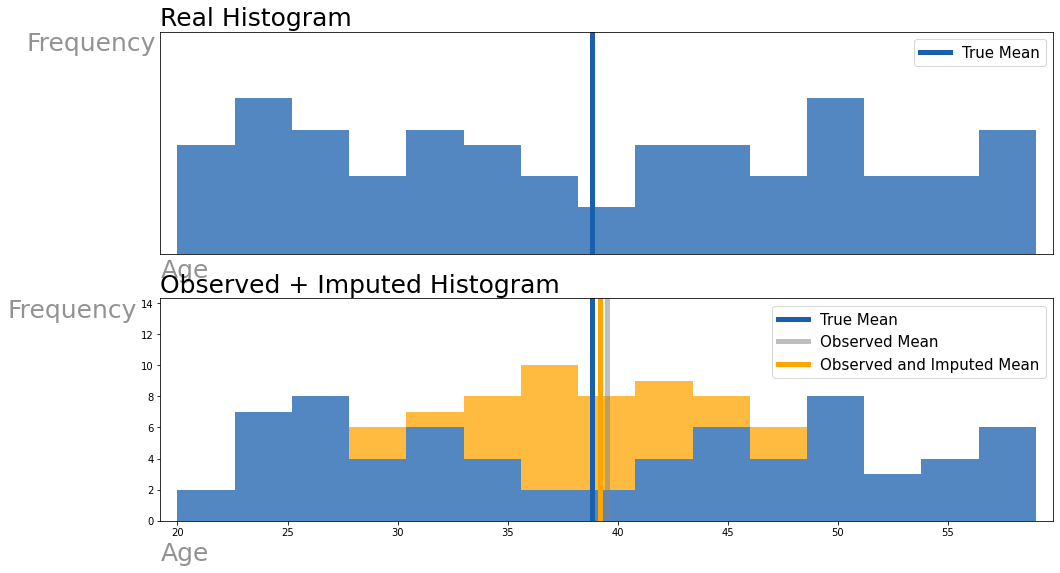

In [20]:
compare_histograms(df = df,
                   imputed_column = 'age_regression_imputed',
                   original_column = 'age',
                   missingness_column = 'age_missingness',
                   x_label = 'Age',
                   y_label = 'Frequency')

In [21]:
np.std(df['age_regression_imputed'], ddof = 1)

10.15023127823849

In [22]:
np.std(df['age'], ddof = 1)

11.900848794107167

### Work in progress:

In [23]:
def compare_scatterplots(df, imputed_column, original_X_column, original_Y_column, missingness_column, x_label, y_label):
    fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))

    # Set axes of scatterplots.
    x_rnge = max(df[original_X_column]) - min(df[original_X_column])
    xmin = min(df[original_X_column]) - 0.1 * x_rnge
    xmax = max(df[original_X_column]) + 0.1 * x_rnge
    y_rnge = max(df[original_Y_column]) - min(df[original_Y_column])
    ymin = min(df[original_Y_column]) - 0.1 * y_rnge
    ymax = max(df[original_Y_column]) + 0.1 * y_rnge

    ax0.set_xlim(xmin, xmax)
    ax0.set_ylim(ymin, ymax)
    ax1.set_xlim(xmin, xmax)
    ax1.set_ylim(ymin, ymax)

    # Set left labels.
    ax0.set_title('Real Scatterplot', position = (0,1), ha = 'left', fontsize = 25)
    ax0.set_xlabel(x_label, position = (0,0), ha = 'left', fontsize = 25, color = 'grey', alpha = 0.85)
    ax0.set_ylabel(y_label, position = (0,1), ha = 'right', va = 'top', fontsize = 25, rotation = 0, color = 'grey', alpha = 0.85)
    ax0.set_xticks([])
    ax0.set_yticks([])

    # Generate left scatterplot.
    ax0.scatter(df[original_X_column], df[original_Y_column], color = '#185fad', alpha = 0.5, label = 'True Values')
    ax0.legend(prop={'size': 15}, loc = 1)
    
    # Set right labels.
    ax1.set_title('Observed + Imputed Scatterplot', position = (0,1), ha = 'left', fontsize = 25)
    ax1.set_xlabel(x_label, position = (0,0), ha = 'left', fontsize = 25, color = 'grey', alpha = 0.85)
    ax1.set_ylabel(y_label, position = (0,1), ha = 'right', va = 'top', fontsize = 25, rotation = 0, color = 'grey', alpha = 0.85)
    ax1.set_xticks([])
    ax1.set_yticks([])

    # Generate right histogram.
    ax1.scatter(df[original_X_column][df[missingness_column] == 1], df[original_Y_column][df[missingness_column] == 1], color = 'orange', alpha = 0.5, label = 'Imputed Values')
    ax1.scatter(df[original_X_column][df[missingness_column] == 0], df[imputed_column][df[missingness_column] == 0], color = '#185fad', alpha = 0.5, label = 'Observed Values')

    ax1.legend(prop={'size': 15}, loc = 1)
    
    plt.show();

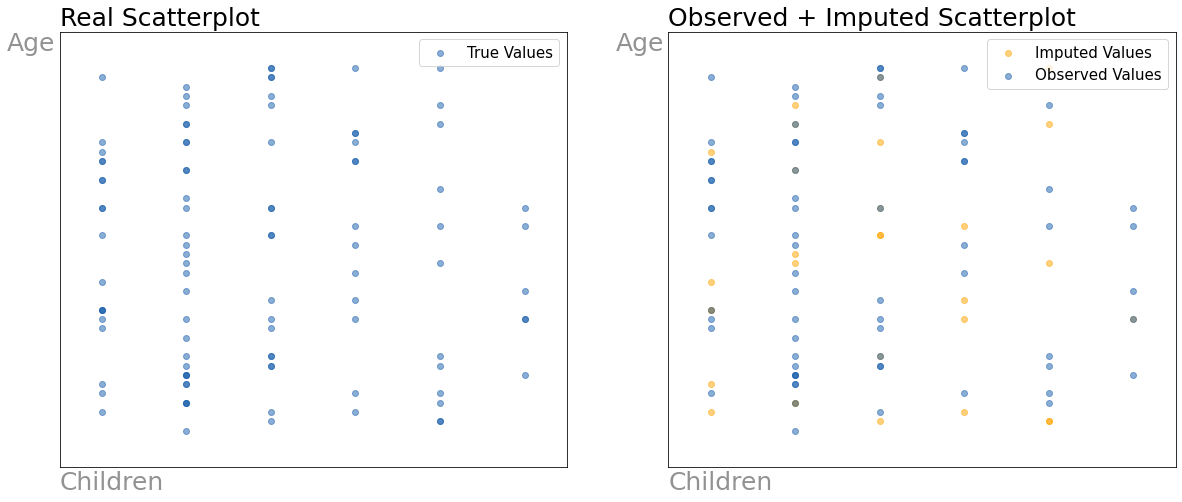

In [24]:
compare_scatterplots(df = df,
                     imputed_column = 'age_regression_imputed',
                     original_X_column = 'children',
                     original_Y_column = 'age',
                     missingness_column = 'age_missingness',
                     x_label = 'Children',
                     y_label = 'Age')

In [28]:
import itertools

In [32]:
cols = ['a', 'b', 'c']
list(itertools.combinations(cols,2))

[('a', 'b'), ('a', 'c'), ('b', 'c')]

In [36]:

for r in range(1,len(cols)+1):
    print(list(itertools.combinations(cols, r)))
     

[('a',), ('b',), ('c',)]
[('a', 'b'), ('a', 'c'), ('b', 'c')]
[('a', 'b', 'c')]


In [27]:
type((1,2))

tuple